<a href="https://colab.research.google.com/github/LanaLana/forest_species/blob/master/Forest_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example of the remote sensing image classification

In this notebook, you can find examples of satellite data processing and analyzing forestry tasks. The notebook consists of data preparation steps for further ML model training and validation. The data presents the Mandrogsky forestry in Leningrad Oblast. The taxation was conducted in 2018-2019 and the corresponding satellite observations were acquired.  

**The problem:** conifer/deciduous forest classification

**Raster data:** Sentinel 13-band image

**Mask:** manual region-based markup, including forest dominant species

In [ ]:
# install library for remote sensing data processing

! pip install rasterio

In [ ]:
%%capture

# upload images for visualization
! curl https://raw.githubusercontent.com/LanaLana/forest_species/master/mandrog.png -o mandrog.png
! curl https://sentinels.copernicus.eu/documents/247904/322303/Performance_Figure_1_full.jpg/8e5f259d-93c7-49eb-95f1-40c1d792ecd7?t=1547715550368 -o bands.png

# upload dataset from file
! curl https://raw.githubusercontent.com/LanaLana/forest_species/master/data/dataset.csv -o dataset.csv

In [3]:
import os
import cv2
import sys
import random
import rasterio
import numpy as np
import tifffile as tiff
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from random import seed
from rasterio.windows import Window

from PIL import Image
from IPython.display import display

## Visualize the study area of Mandrog forestry in taxation data

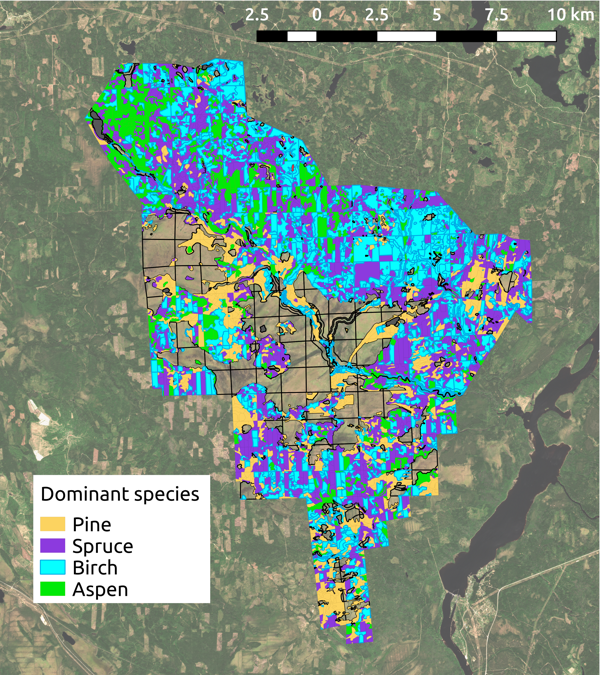

In [4]:
image = Image.open("mandrog.png")
scale = 0.15
display(image.resize(( int(image.width * scale), int(image.height * scale))))

## Download data

For this task, we use multispectral bands from Sentinel-2 satellite. Different ids B01, B02, etc, correspond to different wavelengths. The image was obtained on 2019-08-29. Dataset also contains markup for individual stands (small areas of forest with relatively homogeneous properties). The markup is presented in a binary mask format. For instance, conifer mask equals to 1 in the pixels corresponding to areas with conifer dominant tree species.

The data with satellite images and forestry annotation is available through the link https://disk.yandex.ru/d/YtU6RyT5DjZszg

Let's download it and check

In [7]:
# Get the data, unpack it, and remove zip file
%%capture

! wget https://getfile.dokpub.com/yandex/get/https://disk.yandex.ru/d/YtU6RyT5DjZszg -O ./EO_Browser_images.zip
! unzip ./EO_Browser_images.zip
! rm -f EO_Browser_images.zip

Let's consider the content of the dataset more precisely. The data is presented in the format of tiff files with georeference. The spatial resolution of satellite bands is 10 m per pixel, the markup is also brought to the same spatial resolution.

For each individual stand a dominant species is ascribed. Hence, we obtain individual masks for the following classes:

- aspen
- birch
- spruce
- pine

For the further consideration, we merge aspen and birch into a single class "deciduous", spruce and pine into "conifer".



In [8]:
# list the files in the dataset

! ls ./EO_Browser_images_2

'2019-08-29, Sentinel-2B L1C, B01.tiff'  '2019-08-29, Sentinel-2B L1C, B12.tiff'
'2019-08-29, Sentinel-2B L1C, B02.tiff'  '2019-08-29, Sentinel-2B L1C, B8A.tiff'
'2019-08-29, Sentinel-2B L1C, B03.tiff'  '2019-08-29, Sentinel-2B L1C, True color.tiff'
'2019-08-29, Sentinel-2B L1C, B04.tiff'   aspen.tiff
'2019-08-29, Sentinel-2B L1C, B05.tiff'   birch.tiff
'2019-08-29, Sentinel-2B L1C, B06.tiff'   conifer.tiff
'2019-08-29, Sentinel-2B L1C, B07.tiff'   deciduous.tiff
'2019-08-29, Sentinel-2B L1C, B08.tiff'   ind_map.tiff
'2019-08-29, Sentinel-2B L1C, B09.tiff'   pine.tiff
'2019-08-29, Sentinel-2B L1C, B10.tiff'   spruce.tiff
'2019-08-29, Sentinel-2B L1C, B11.tiff'


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  171k  100  171k    0     0   101k      0  0:00:01  0:00:01 --:--:--  101k


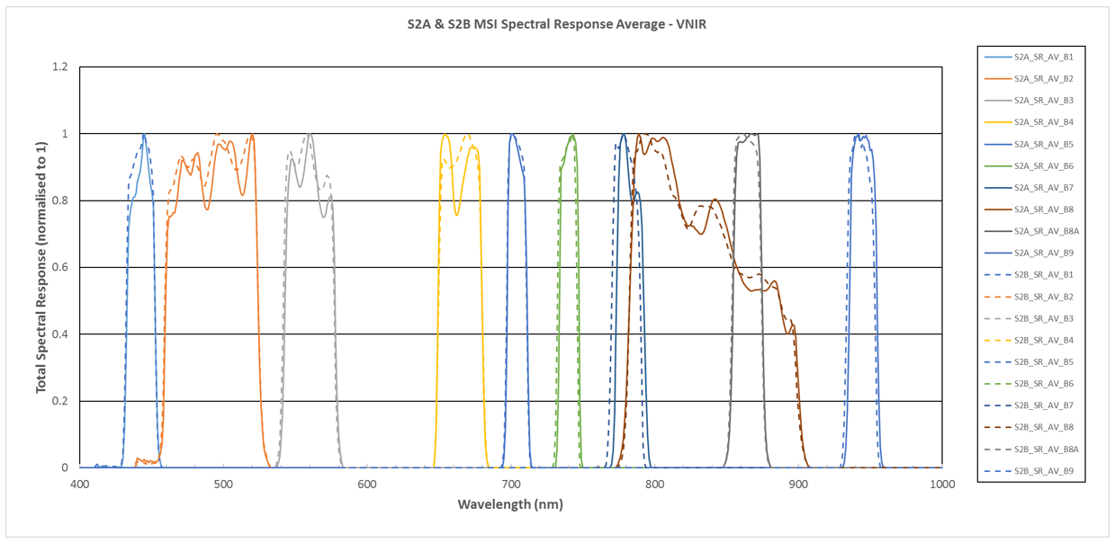

In [9]:
image = Image.open("bands.png")
scale = 0.9
display(image.resize(( int(image.width * scale), int(image.height * scale))))

## Visualize markup for conifer and deciduous

We can visualize these target classes

In [10]:
# read raster files

with rasterio.open('EO_Browser_images_2/deciduous.tiff') as src:
    deciduous_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/conifer.tiff') as src:
    conifer_mask = src.read(1)

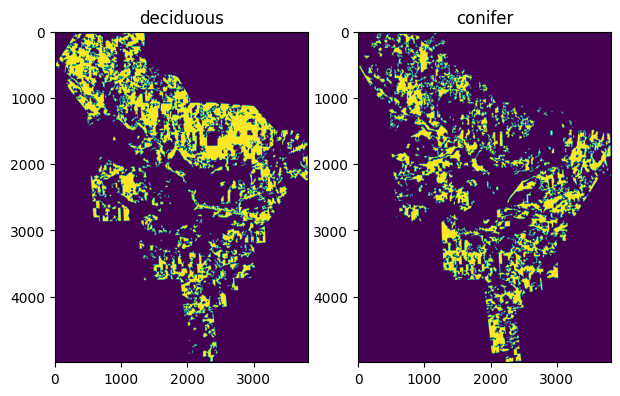

In [11]:
# plot maps with 0 and 1 values for the background and the target class

fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
a.set_title('deciduous')
imgplot = plt.imshow(deciduous_mask)

a = fig.add_subplot(1, 4, 2)
a.set_title('conifer')
imgplot = plt.imshow(conifer_mask)

In [12]:
# check the list of unique values in the maps

np.unique(conifer_mask)

array([0, 1], dtype=uint8)

We can count the number of pixels in each class

In [13]:
print('pixels for deciduous:', np.sum(deciduous_mask))
print('pixels for conifer:', np.sum(conifer_mask))

pixels for deciduous: 3358398
pixels for conifer: 2741467


## Visualize markup for 4 classes

In [14]:
# read maps for all 4 classes

with rasterio.open('EO_Browser_images_2/aspen.tiff') as src:
    aspen_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/pine.tiff') as src:
    pine_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/birch.tiff') as src:
    birch_mask = src.read(1)
with rasterio.open('EO_Browser_images_2/spruce.tiff') as src:
    spruce_mask = src.read(1)

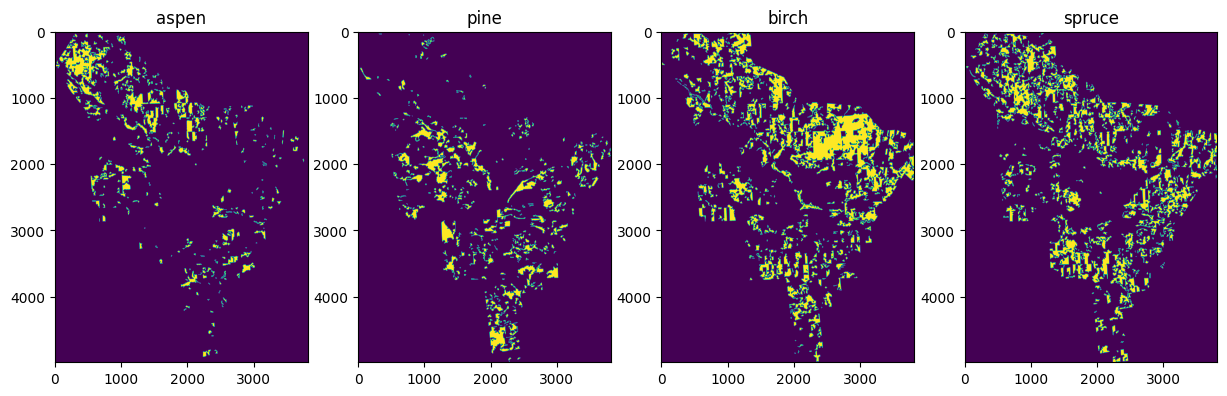

In [15]:
# draw maps with the target classes for aspen, birch, spruce, and pine

fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
a.set_title('aspen')
imgplot = plt.imshow(aspen_mask)

a = fig.add_subplot(1, 4, 2)
a.set_title('pine')
imgplot = plt.imshow(pine_mask)

a = fig.add_subplot(1, 4, 3)
a.set_title('birch')
imgplot = plt.imshow(birch_mask)

a = fig.add_subplot(1, 4, 4)
a.set_title('spruce')
imgplot = plt.imshow(spruce_mask)

In [16]:
# check intersection between classes; if the intersection equals to 0 than each
# individual stand has a unique label and the splitting is correct

np.sum(np.where(aspen_mask+pine_mask+birch_mask+spruce_mask>1, 1, 0))

0

## Visualize satellite data

We can read now spectral bands corresponding to the Red, Green, and Blue spectrum (B04, B03, and B02, respectively)

In [17]:
# read RGB bands from Sentinel-2 bands

with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B04.tiff') as src:
    r = src.read(1)
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B03.tiff') as src:
    g = src.read(1)
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B02.tiff') as src:
    b = src.read(1)

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7a5b7c5de890>)

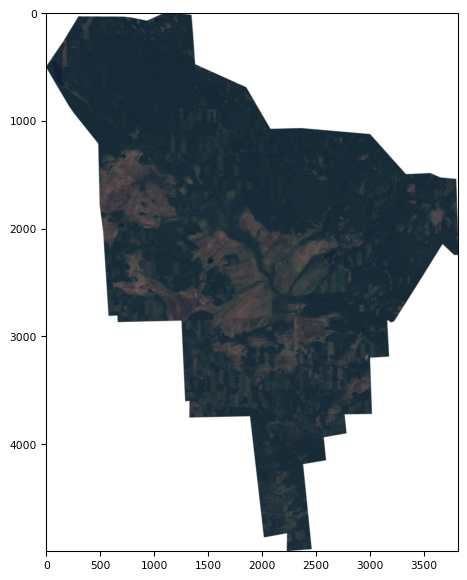

In [18]:
# visualize RGB composite merged from Red, Green, and Blue bands

tiff.imshow(np.asarray([r, g, b]))

Let's consider smaller patch from the original vast forestry. The patch size is 500 per 500 pixels. Recall, that pixel size is 10 per 10 m.

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7a5b7c653730>)

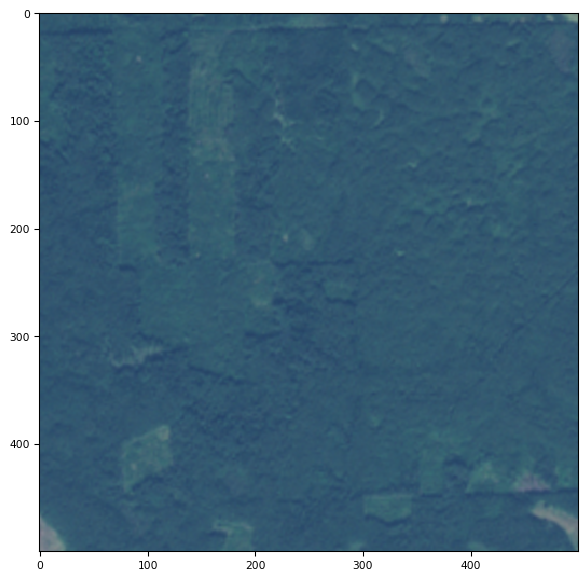

In [19]:
tiff.imshow(np.asarray([r, g, b])[:,1500:2000,2000:2500])

We can then observe NIR (near infra-red) band from the Sentinel-2 image for the same region. The NIR band has the index B05 in the original notation of this satellite.

In [20]:
# read Near Infra-Red band (NIR)

with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B05.tiff') as src:
    channel_B05 = src.read(1)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7a5b757d3a60>)

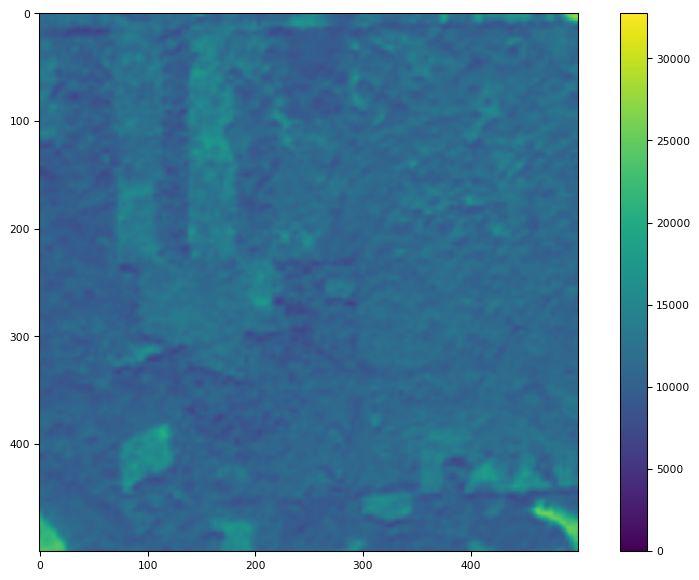

In [21]:
tiff.imshow(channel_B05[1500:2000,2000:2500])

This spectral band provides additional information and is useful for vegetation cover analysis.

## Load map of individual forest regions

The forestry is split into individual forest inventory stands (small regions with similar characteristics). We will agregate information for each individual stand. An individual stand has its index. This information is presented in the file "ind_map.tiff". We will extract coordinates of each individual stand and then consider pixels' values within this area.

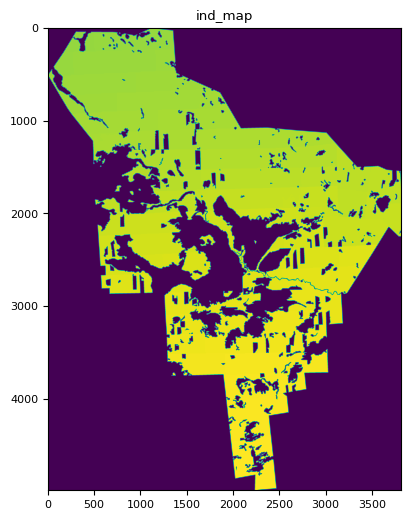

In [22]:
# read raster file with map of individual stands

with rasterio.open('EO_Browser_images_2/ind_map.tiff') as src:
    ind_map = src.read(1)

# visualize all individual stands

fig = plt.figure(figsize=(6, 6))

a = fig.add_subplot(1, 1, 1)
a.set_title('ind_map')
imgplot = plt.imshow(ind_map)

Let's find all unique values of all individual stands

In [23]:
np.unique(ind_map)

array([      0, 1001001, 1001002, ..., 1187021, 1187022, 1187023],
      dtype=uint32)

And count the total number of individual stands in the forestry

In [24]:
print('number of individual regions:', len((np.unique(ind_map))))

number of individual regions: 4898


Now let's take some random ID from the middle of the forestry

In [25]:
# some index in the middle of the IDs list

np.unique(ind_map)[len(np.unique(ind_map))//2]

1091005

We can now visualize all stands that have ID number larger than the medium value from the value obtained in previous cell. The map is represent in a binary format (just 0 and 1 values)

(<Figure size 988.8x604.8 with 2 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7a5b732dff70>)

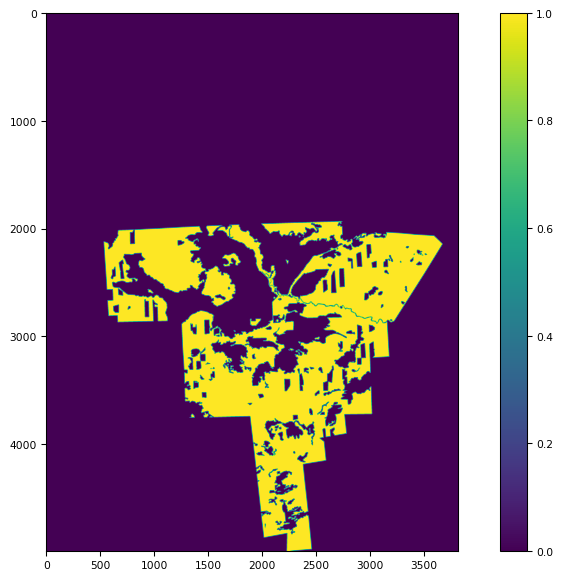

In [26]:
tiff.imshow(np.where(ind_map>np.unique(ind_map)[len(np.unique(ind_map))//2], 1, 0))

This splitting can be further used to divide the dataset into training and validation subsets based on the spatial distribution

### Count number of individual regions for each class

Now, we can count the total number of stands for the class conifer and diciduous by considering the intersection between individual stand ID and the value in map with the target class. We need this information to understand the distribution of the dataset.

You can skip this cell, because it takes a few minutes to compute. Take a look on the output of the next cell with the count of individual stands for each of two classes

In [ ]:
# statistics = {'conifer':0, 'deciduous':0}
# for region_id in np.unique(ind_map)[1:]:
#     #the first ocurrence of the particular index
#     i, j = np.where(ind_map==region_id)
#     statistics['conifer'] += conifer_mask[i[0], j[0]]
#     statistics['deciduous'] += deciduous_mask[i[0], j[0]]

In [ ]:
# print('number of conifer regions: ',statistics['conifer'])
# print('number of deciduous regions: ', statistics['deciduous'])

number of conifer regions:  2365
number of deciduous regions:  2112


***

***

# Machine learning model

### Prepare dataset

"extract_features_1" function computes statistics for all pixels within each individual stand. Therefore, for our machine learning model we consider an individual stand as an object with the following feature vectore: min value for each spectral channel, max value for each channel and so on.

In [ ]:
# compute features for each individual forest region

MAX_CONST = 65535 # the maximum value in the Sentinel-2 bands

def min_val(a): return np.min(a[a>0])
def max_val(a): return np.max(a[a<MAX_CONST])
def mean_val(a): return np.mean(a[a>0])
def std_val(a): return np.std(a[a>0])

def extract_features_1(ind_region, window):
    """
    the function computes the main statistics using the ID of individual stand
    and the window -- bounding box of this individual stand;
    ind_map is the map with individual stands' IDs, it is used to identufy the
    boundary of each stand;

    output: the dictinory with feautires' names and the corresponding values'
    """
    func_list = {'min':min_val, 'max':max_val, 'mean':mean_val, 'std':std_val}
    feature_list = {}
    masked_region = np.where(ind_map == ind_region, 1, 0)[window.col_off:window.col_off+window.width,\
                                                          window.row_off:window.row_off+window.height]

    window = Window(window.row_off, window.col_off, window.height,window.width)
    for band in range(1, 13): # statistics are computed for each band
        if band < 10:
            band = '0' + str(band)
        with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B{}.tiff'.format(band)) as src:
            tmp_img = src.read(1, window=window)

        region_of_interest = tmp_img * masked_region * np.where(tmp_img==MAX_CONST, 0, 1)
        for func in func_list.keys():
            feature_list[func+'_'+str(band)] = func_list[func](region_of_interest)

    return feature_list

You can run this code and creat dataset or just load dataset from the file it takes a few minutes to create dataset

In [ ]:
# X_train = []
# Y_train = []
# for k, ind_region in enumerate(np.unique(ind_map)[1:]):
#     i, j = np.where(ind_map==ind_region)
#     if conifer_mask[i[0], j[0]] + deciduous_mask[i[0], j[0]] == 0:
#         continue #there are not classes of our interest
#     window = Window(np.min(i), np.min(j), np.max(i)-np.min(i), np.max(j)-np.min(j))
#     if np.max(i)-np.min(i)<3 and np.max(j)-np.min(j)<3:
#         continue #region is too small, lets skip it
#     Y_train += [conifer_mask[i[0], j[0]]]
#     X_train += [extract_features_1(ind_region=ind_region, window=window)]
#     if k % 100 == 0:
#         print(k, len(np.unique(ind_map))) #just to monitor the process

In [ ]:
# X_df = pd.DataFrame(X_train)
# X_df['y'] = Y_train

## Visualize individual stand

Let's visualize some random individual stand, for instance with ID = 1170. We can observe the shape of its boundaries and the RGB composite inside this region. Neighbouring areas (background) are painted in black.  

(<Figure size 988.8x604.8 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7a5b73267c40>)

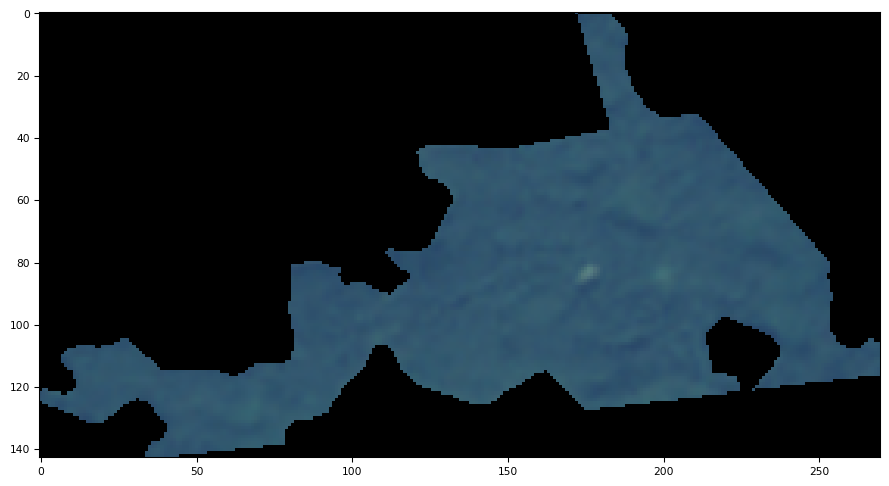

In [29]:
ind_region = np.unique(ind_map)[1170] # set ID of individual stand
i, j = np.where(ind_map==ind_region) # estimate the border-line of individual stand
window = Window(np.min(i), np.min(j), np.max(i)-np.min(i), np.max(j)-np.min(j)) # create window with bounding box of individual stand
# mask the region of the individual stand
masked_region = np.where(ind_map == ind_region, 1, 0)[window.col_off:window.col_off+window.width,\
                                                          window.row_off:window.row_off+window.height]

window = Window(window.row_off, window.col_off, window.height,window.width)

# read RGB composite of this individual stand and mask pixel outside this area
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B04.tiff') as src:
    r = src.read(1, window=window) * masked_region
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B03.tiff') as src:
    g = src.read(1, window=window) * masked_region
with rasterio.open('EO_Browser_images_2/2019-08-29, Sentinel-2B L1C, B02.tiff') as src:
    b = src.read(1, window=window) * masked_region

# visualize masked RGB composite with the individual stand
tiff.imshow(np.asarray([r, g, b]))

## Upload dataset from file

Let's read the dataset in the CSV format with tabular data and consider the first rows in the dataframe.

In [40]:
X_df = pd.read_csv('dataset.csv', index_col=[0])

In [41]:
X_df.head()

,min_01,max_01,mean_01,std_01,min_02,max_02,mean_02,std_02,min_03,max_03,...,std_10,min_11,max_11,mean_11,std_11,min_12,max_12,mean_12,std_12,y
1749,19267,19513,19381.892308,69.819465,13762,14909,14303.903846,236.955356,10240,12190,...,8.186143,8946,14713,12263.626923,1892.078898,3506,6373,4998.930769,922.322893,1
1125,19726,20693,20049.605697,227.500292,14156,15974,15142.173913,386.704091,10813,13549,...,14.323158,13140,29360,19984.376312,4116.971095,5702,13500,8872.287856,1993.362361,1
337,19071,19398,19211.098039,60.537976,13386,14876,13954.702317,234.193543,9191,12353,...,13.445034,7831,18825,11306.733809,2033.594249,2785,6881,4255.816399,772.771491,1
229,20070,20349,20175.965308,68.090730,13762,15548,14560.555074,256.991468,9814,13517,...,14.975735,12534,24576,17122.533391,2254.297107,4735,9503,6188.291414,901.553588,0
2191,19366,19497,19412.986547,32.792523,13779,15106,14312.213004,190.599766,10060,12681,...,9.526969,12681,18940,16091.508969,1462.338346,4555,6996,5902.659193,515.104487,0


In [42]:
#splite into train and test

X_train_df = X_df[:3400]
X_test_df = X_df[3400:]

In [43]:
pd.options.mode.chained_assignment = None

y_train_df = X_train_df["y"]
X_train_df.drop(labels="y", axis=1, inplace=True)

y_test_df = X_test_df["y"]
X_test_df.drop(labels="y", axis=1, inplace=True)

Now let's check that in the training dataset there are only the correct features without the labels

In [44]:
X_train_df.columns

Index(['min_01', 'max_01', 'mean_01', 'std_01', 'min_02', 'max_02', 'mean_02',
       'std_02', 'min_03', 'max_03', 'mean_03', 'std_03', 'min_04', 'max_04',
       'mean_04', 'std_04', 'min_05', 'max_05', 'mean_05', 'std_05', 'min_06',
       'max_06', 'mean_06', 'std_06', 'min_07', 'max_07', 'mean_07', 'std_07',
       'min_08', 'max_08', 'mean_08', 'std_08', 'min_09', 'max_09', 'mean_09',
       'std_09', 'min_10', 'max_10', 'mean_10', 'std_10', 'min_11', 'max_11',
       'mean_11', 'std_11', 'min_12', 'max_12', 'mean_12', 'std_12'],
      dtype='object')

The "y" consists of the labels of the target classes

In [45]:
y_train_df

,y
1749,1
1125,1
337,1
229,0
2191,0
...,...
1610,0
1166,0
3091,1
797,0


### Train model

Now you have dataset and you are ready to creat a machine learning model. You can import models from sklearn.

To evaluate results, please, use confusion_matrix function from sklearn. You can also use classification_report function.

In [46]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier

Now you need to define classifier. It can be GradientBoostingClassifier. Details are provided through the link https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html


0. initialize model
1.   Use default parameters
2.   Implement "fit" method of the defined in the previous step model
3.   Implement "predict" method of the trained in the previous step model
4.   Compute model quality and print Confusion Matrix and Classification report
5.   Try different parameters to improve model quality

You can try to change the following parameters and evaluate the quality:

**learning_rate float, default=0.1**
Learning rate shrinks the contribution of each tree by learning_rate. There is a trade-off between learning_rate and n_estimators.

**n_estimators int, default=100**
The number of boosting stages to perform. Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.

**max_depth int, default=3**
The maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.




In [47]:
state = 12
test_size = 0.3

_X_train, X_val, _y_train, y_val = train_test_split(X_train_df, y_train_df,
                                                    test_size=test_size,
                                                    random_state=state)

In [48]:
gb_clf2 = GradientBoostingClassifier(n_estimators=20, learning_rate=0.5,
                                     max_features=2, max_depth=2, random_state=0)
gb_clf2.fit(_X_train, _y_train)
predictions = gb_clf2.predict(X_val)

print("Confusion Matrix:")
print(confusion_matrix(y_val, predictions))

print("Classification Report")
print(classification_report(y_val, predictions))

Confusion Matrix:
[[359 121]
 [ 77 463]]
Classification Report
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       480
           1       0.79      0.86      0.82       540

    accuracy                           0.81      1020
   macro avg       0.81      0.80      0.80      1020
weighted avg       0.81      0.81      0.81      1020



In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)
rf.fit(X_train_df, y_train_df)
predictions = rf.predict() # add test features for prediction

In [ ]:
print("Confusion Matrix:")
#your code here, use confusion_matrix(...)
# compare predictions and ground truth (y_test_df)

print("Classification Report")
#your code here, use classification_report(...)

Confusion Matrix:
Classification Report


## Other algorithms

You can try to train Random Forest and SVM algorithms

In [ ]:
# your code here

## Other features

You can modify function extract_features_1 and create your own dataset with additional vegetation indexes. For example **NDVI** (Normalized difference vegetation index) is computed using the following function:

NDVI = (NIR - RED) / (NIR + RED)

It is a commonly used index in vegetation tasks as it describes plants condition. For Sentinel-2 imagery, the formula includes B8 and B4 bands that corespond to NIR and RED channels respectively:

NDVI = (B8 - B4) / (B8 + B4)

You can also explore and add other features

In [ ]:
# your code here

## Random Forest feature importances

Let us fit a random forest classifier and see which features were deemed important by the model by plotting the feature importances.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(n_estimators=100)
rf.fit(_X_train, _y_train)

RandomForestClassifier()

In [ ]:
col_sorted_by_importance=rf.feature_importances_.argsort()
feat_imp=pd.DataFrame({
    'cols':_X_train.columns[col_sorted_by_importance],
    'imps':rf.feature_importances_[col_sorted_by_importance]
})

In [ ]:
!pip install plotly_express --upgrade -q

In [ ]:
import plotly_express as px
import plotly.offline as po
px.bar(feat_imp.sort_values(['imps'], ascending=False)[:25], x='cols', y='imps', labels={'cols':'column', 'imps':'feature importance'})

## Permutation importance

Permutation importance is a technique where we shuffle the values of a single column and run the model to see how the scores get affected. If the scores are affected greatly, then the feature is highly important to the model and if not, it does not add significant value to the model.

Let us see the feature importances for recall score on the test dataset.

In [ ]:
def PermImportance(X, y, clf, metric, num_iterations=100):
    '''
    Calculates the permutation importance of features in a dataset.
    Inputs:
    X: dataframe with all the features
    y: array-like sequence of labels
    clf: sklearn classifier, already trained on training data
    metric: sklearn metric, such as accuracy_score, precision_score or recall_score
    num_iterations: no. of repetitive runs of the permutation
    Outputs:
    baseline: the baseline metric without any of the columns permutated
    scores: differences in baseline metric caused by permutation of each feature, dict in the format {feature:[diffs]}
    '''
    bar=progressbar.ProgressBar(max_value=len(X.columns))
    baseline_metric=metric(y, clf.predict(X))
    scores={c:[] for c in X.columns}
    for c in X.columns:
        X1=X.copy(deep=True)
        for _ in range(num_iterations):
            temp=X1[c].tolist()
            random.shuffle(temp)
            X1[c]=temp
            score=metric(y, clf.predict(X1))
            scores[c].append(baseline_metric-score)
        bar.update(X.columns.tolist().index(c))
    return baseline_metric, scores

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import progressbar
baseline, scores=PermImportance(X_test_df, y_test_df, rf, recall_score, num_iterations=10)

 97% (48 of 49) |####################### | Elapsed Time: 0:00:21 ETA:   0:00:00

In [ ]:
percent_changes={c:[] for c in X_test_df.columns}
for c in scores:
    for i in range(len(scores[c])):
        percent_changes[c].append(scores[c][i]/baseline*100)

In [ ]:
px.bar(
    pd.DataFrame.from_dict(percent_changes).melt().groupby(['variable']).mean().reset_index().sort_values(['value'], ascending=False)[:25],
    x='variable',
    y='value',
    labels={
        'variable':'column',
        'value':'% change in recall'
        }
       )

***

***